# Graded Exercise 2: Anomaly Detection on Acoustic Data

- **Course**: [CIVIL-426 - Machine Learning for Predictive Maintenance](https://edu.epfl.ch/coursebook/en/machine-learning-for-predictive-maintenance-applications-CIVIL-426)
- **Start Date**: 2024.10.03 at 10:15
- **Due Date**: 2024.10.16 at 23:59
- **Student 0**:
    - Name: Joshua Cohen-Dumani
    - SCIPER: 311105
- **Student 1**:
    - Name: Sophea Bonne
    - SCIPER: 352901

# Introduction
Anomalous sound detection (ASD) refers to the task of identifying whether the sounds emitted from a target machine are normal or anomalous.
In real-world industrial environments, anomalies are infrequent and can exhibit significant variability, making it impractical to build an exhaustive set of anomalous sound patterns.
As a result, our goal is to detect anomalous sounds using only normal sound clips for training.

This challenge cannot be approached as a simple classification problem (anomaly vs healthy). Instead, it is formulated as a **one-class classification** problem, where the model is trained on normal sound data to detect deviations from the learned pattern.

Anomalous sound detection can be achieved with following steps:
   - Feature Extraction (I)
   - One-class Classifier Training (II)
   - Decisions based on a threshold from your trained classifier (III)
   
Through this assignment, you will primarily focus on tasks (I) and (II).
The quality of your one-class classifier will be assessed using the **Area Under the Curve (AUC)** score on the test dataset.

The model used here is a type of neural network called **AutoEncoder** (AE). AE is trained to reconstruct the input data while compressing the input data into a lower-dimensional latent space and minimizing information loss during this process.
Thus, you will also modify the extracted features and Neural Network used in this notebook to improve the anomalous sound detection performance.

The dataset is composed of two different machines, a Pump and a Valve. For each machine you have:
- A **training dataset** composed of *only healthy* sound data
- A **test dataset** composed of *both healthy and abnormal* sound data

# Questions:

Your task is to improve the anomalous sound detection performance by modifying the feature extraction process and neural network architecture. You are expected to experiment with various feature representations and neural network configurations to optimize detection results.

Specifically, the following questions must be addressed. Each question should be discussed separately for both the Pump and Valve datasets. The answers are to be provided in a PDF report, and the full Jupyter notebook must also be submitted.

**Question 1:** Given the provided code, fill in the blank spaces to extract signal features, train a simple AutoEncoder that reconstructs the inputs MEL-Spectogram, and report the AUC score.

**Question 2:** From the trained AutoEncoder, use the bottleneck features to train both (1) a One-Class SVM and (2) an Isolation Forest, and report the corresponding AUC scores.

**Question 3:** Instead of using AutoEncoder features, apply PCA to project the MEL-spectrogram into a smaller dimensional space, then train (1) a One-Class SVM and (2) an Isolation Forest, and report the AUC scores.

**Question 4:** Determine an appropriate threshold for distinguishing anomalies based on the given results, and compute the following metrics: Accuracy, True Positive Rate (TPR), False Positive Rate (FPR), and F1-score.

**Question 5:** Visualize essential steps and provide a thorough discussion of the results obtained from all the methods.  

**Bonus Question:** Modify the AutoEncoder architecture to a 2D AutoEncoder using convolutional layers instead of fully connected layers, and analyze its performance.

## Download Dataset

In [144]:
%pip install gdown --upgrade --quiet
import gdown
import os

Note: you may need to restart the kernel to use updated packages.


In [145]:
# pump dataset
if not os.path.exists('dev_data_pump_04'):
    print('Downloading and unzipping dev_data_pump_04.zip...')
    gdown.download(id='1ZAqnNW2gnHDyFHGHk3Aru7k-ng-BTpGn', output="./dev_data_pump_04.zip")
    !unzip dev_data_pump_04.zip
else:
    print('Directory dev_data_pump_04 already exists, skipping download and unzip.')


Directory dev_data_pump_04 already exists, skipping download and unzip.


In [146]:
# Valve Dataset
if not os.path.exists('dev_data_valve_00'):
    print('Downloading and unzipping dev_data_valve_00.zip...')
    gdown.download(id='1H_SS7qteLcd44e5CD9CFJjhJ573FAb6M', output="./dev_data_valve_00.zip")
    !unzip dev_data_valve_00.zip
else:
    print('Directory dev_data_valve_00 already exists, skipping download and unzip.')

Directory dev_data_valve_00 already exists, skipping download and unzip.


In case that above links do not work, you can also manully download the dataset here:
- **dev_data_pump_04.zip**: https://docs.google.com/uc?export=download&id=1ZAqnNW2gnHDyFHGHk3Aru7k-ng-BTpGn
- **dev_data_valve_00,zip**: https://docs.google.com/uc?export=download&id=1H_SS7qteLcd44e5CD9CFJjhJ573FAb6M

## Import Dependency

In [147]:
import sys
import librosa
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from tqdm import tqdm
import seaborn as sns

# VALVE

# Question 1: Autoencoder
### Given the provided code, fill in the blank spaces to extract signal features, train a simple AutoEncoder that reconstructs the inputs MEL-Spectogram, and report the AUC score.

## Audio Data Loading and MEL-Spectrogram Feature Extraction

The code is adapted from https://github.com/MIMII-hitachi/mimii_baseline

Copyright (C) 2019 Hitachi, Ltd. All right reserved.

Harsh Purohit, Ryo Tanabe, Kenji Ichige, Takashi Endo, Yuki Nikaido, Kaori Suefusa, and Yohei Kawaguchi, "MIMII Dataset: Sound Dataset for Malfunctioning Industrial Machine Investigation and Inspection," arXiv preprint arXiv:1909.09347, 2019.

In [384]:
########################################################################
# import additional python-library
########################################################################
import librosa.core
import librosa.feature

# WAV File Input
def load_wav_files(wav_file_name, mono=True):
    """Load a .wav file."""
    try:
        return librosa.load(wav_file_name, sr=None, mono=mono)
    except Exception as e:
        print(f"Failed to load file '{wav_file_name}'. Error: {e}")
        raise

def demux_wav_files(wav_file_name, channel=0):
    """Demux a .wav file and return a specific channel."""
    try:
        multi_channel_data, sr = load_wav_files(wav_file_name, mono=False)
        if multi_channel_data.ndim == 1:
            return sr, multi_channel_data
        return sr, multi_channel_data[channel, :]
    except ValueError as e:
        print(f"Error in demuxing file '{wav_file_name}': {e}")
        raise

# Feel free to modify and analysis the images in your report
def plot_signals(tmin, tmax, sr, y, emphasized_y, log_mel_spectrogram):
    plt.figure(1)
    n = len(y)
    t = np.linspace(tmin, tmax, n)
    plt.plot(t, y)
    plt.xlim(t[0],t[-1])
    plt.xlabel('time/s',fontsize=20)
    plt.ylabel('Amplitude',fontsize=20)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid()
    
    plt.figure(2)
    freq = sr/n*np.linspace(0,n/2,int(n/2)+1)
    plt.plot(freq,np.absolute(np.fft.rfft(y[tmin*sr:tmax*sr],n)**2)/n)
    plt.xlim(0,5000)
    plt.xlabel('Frequency/Hz',fontsize=14)
    
    plt.figure(3)
    plt.plot(freq,np.absolute(np.fft.rfft(emphasized_y,n)**2)/n)
    plt.xlim(0,5000)
    plt.xlabel('Frequency/Hz',fontsize=14)
    
    plt.figure(4)
    librosa.display.specshow(log_mel_spectrogram)
    plt.colorbar()

########################################################################
# Feature Extractor
########################################################################
def file_to_features(file_name,
                     n_mels=64,
                     frames=5,
                     n_fft=1024,
                     hop_length=512,
                     power=2.0,
                     plot=True):
    """Convert a WAV file to a vector array."""
    # Step 01: Load the demuxed wav files
    sr, y = demux_wav_files(file_name, channel=0)
    
    # Step 02: Signal Pre-emphasis
    tmin = int(0)
    tmax = int(len(y)/sr)
    alpha = 0.95
    emphasized_y = np.append(y[0],
                             y[1:] - alpha*y[:-1])
    
    # Step 03: Generate MEL-Spectrogram
    # ===================================
    mel_spec = librosa.feature.melspectrogram(y=emphasized_y, 
                                              sr=sr, 
                                              n_fft=n_fft, 
                                              hop_length=hop_length, 
                                              power=power, 
                                              n_mels=n_mels)
    # ===================================

    # Step 04: Convert MEL-Spectrogram to log scale
    # ===================================
    log_mel_spectrogram = librosa.power_to_db(mel_spec, ref=np.max)
    # ===================================
    
    
    # Step 05: Define Feature Vector Array
    dims = n_mels * frames
    length = len(log_mel_spectrogram[0,:]) - frames + 1
    features = np.zeros((length, dims), float)
    
    # Pad short clips instead of skipping
    if length < 1:
        print(f"Audio file '{file_name}' is too short. Padding applied.")
        log_mel_spectrogram = np.pad(log_mel_spectrogram, ((0, 0), (0, frames - 1)), mode='constant')
        length = 1
    
    for t in range(frames):
        features[:, n_mels * t: n_mels * (t + 1)] = log_mel_spectrogram[:, t: t + length].T
    
    if plot:
        plot_signals(tmin, tmax, sr, y, emphasized_y, log_mel_spectrogram)
    return features

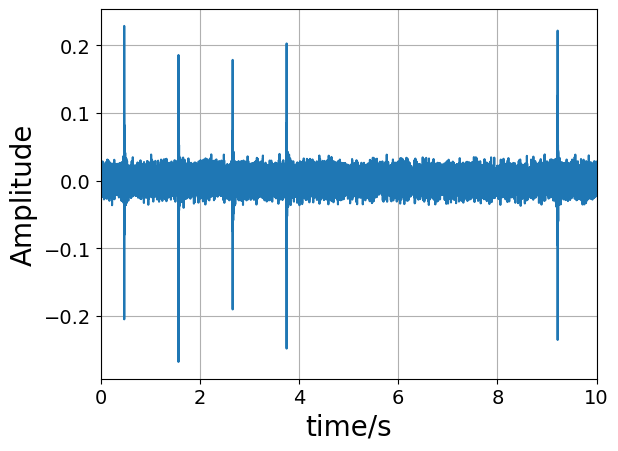

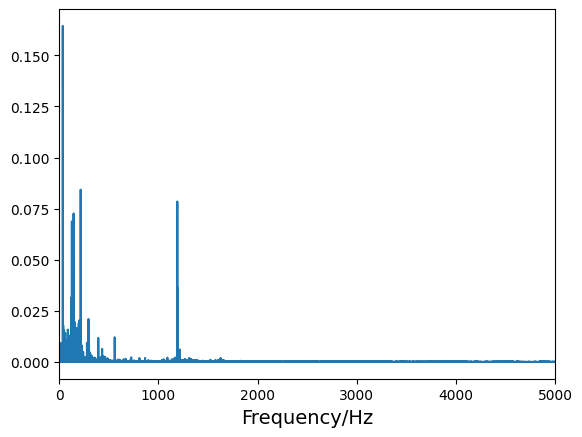

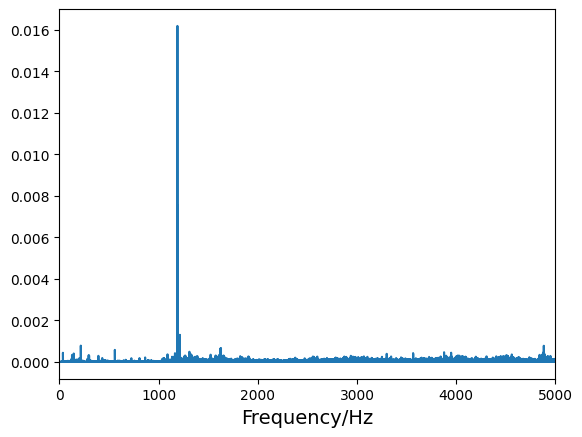

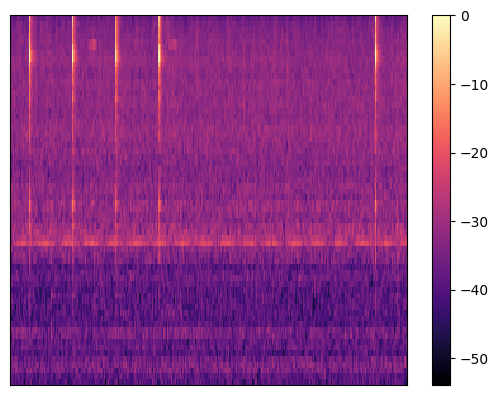

In [385]:
wav_test_file = 'dev_data_valve_00/valve/train/normal_id_00_00000000.wav'
# wav_test_file = 'dev_data_valve_00/valve/test/anomaly_id_00_00000009.wav'

# Visualize your results for potential analysis in your report
features = file_to_features(wav_test_file)

## PyTorch Dataset Splitting

To define and optimize a neural network, we will use the library [PyTorch](http://pytorch.org).

In [386]:
DATA_PATH = "."
MACHINE = "valve_00" # Choice between  "valve_00" or "pump_04"

In [387]:
class MIMII(Dataset):
    def __init__(self, root, machine, train=True, transform=None, target_transform=None):
        if train:
            self.audio_path = os.path.join(root, f"dev_data_{machine}", machine.split("_")[0], "train")
            self.audio_files = os.listdir(self.audio_path)
            self.labels = [int(f.split("_")[0] == "anomaly") for f in self.audio_files]
        else:
            self.audio_path = os.path.join(root, f"dev_data_{machine}", machine.split("_")[0], "test")
            self.audio_files = os.listdir(self.audio_path)
            self.labels = [int(f.split("_")[0] == "anomaly") for f in self.audio_files]
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.audio_files)

    def __getitem__(self, idx):
        file_path = os.path.join(self.audio_path, self.audio_files[idx])
        label = self.labels[idx]
        if self.transform:
            f = self.transform(file_path)
        else:
            # default feature representation
            f = file_to_features(file_path).astype(np.float32)
        if self.target_transform:
            label = self.target_transform(label)
        return f, label

In [388]:
# Parameters of the feature extraction
melsp_params = dict(n_mels=64,
                    frames=1,
                    n_fft=1024,
                    hop_length=512,
                    power=2.0,
                    plot=False)


feature_extraction_pipeline = T.Compose([
    T.Lambda(lambda file: file_to_features(file, **melsp_params).astype(np.float32)),
    T.ToTensor()
])

In [389]:
# Pytorch train/test datasets
data_train = MIMII(
    root=DATA_PATH,
    machine=MACHINE,
    train=True,
    transform=feature_extraction_pipeline
)

data_test = MIMII(
    root=DATA_PATH,
    machine=MACHINE,
    train=False,
    transform=feature_extraction_pipeline
)

## AutoEncoder Model Definition

After splitting the dataset and defining our key features, we can move on to model definition and training. Here we will be building a symmetrical autoencoder, defining the decoder symmetrically to the encoder.

In [390]:
class DenseAutoencoder(nn.Module):

    def __init__(self, input_dim):
        super(DenseAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 32),
            )
        
        # Symetrical neural network to the encoder to reconstuct the input
        # ===================================
        self.decoder = nn.Sequential(
        nn.Linear(32, 128),        
        nn.ReLU(),
        nn.Linear(128, 512),      
        nn.ReLU(),
        nn.Linear(512, input_dim), 
        )
        # ===================================

    def forward(self, x):
        feature = self.encoder(x)
        reconstruction = self.decoder(feature)
        return reconstruction,feature

In [391]:
duration = 10  # s
sr = 16000  # Hz
input_dim = int(duration * sr / melsp_params["hop_length"] + 1) * melsp_params["n_mels"] * melsp_params["frames"]
model = DenseAutoencoder(input_dim)

## Training


Now that the autoencoder is defined we can move onto training. We will be training for 10 epochs (we tried training for more but the loss doesn't seem to improve much more), with a batch sze of 32 (given hyperparam). Over the training loop we will be reconstructing the Mel Spectrogram features extracted in the above dataset construction.

In [392]:
# Training parameters
batch_size = 32
epochs = 10

In [393]:
# PyTorch data loaders allow to iterate batch-wise over a dataset
train_loader = DataLoader(data_train, batch_size=batch_size, shuffle=True, drop_last=True)

In [394]:
# Stochastic gradient descent optimizer
optimizer = torch.optim.Adam(model.parameters())

# Mean Squared Error (MSE) loss function to be minimized
loss_fn = nn.MSELoss()

In [395]:
def train_loop(dataloader, model, loss_fn, optimizer, print_every=10):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    loss_running = 0
    for batch, (x, y) in enumerate(tqdm(dataloader)):
        # Compute prediction and loss
        x = x.flatten(start_dim=1)
        optimizer.zero_grad()
        x_pred, features = model(x)
        
        # TODO : write the loss function, compute the gradient, and update the model parameters
        # ===================================
        loss = loss_fn(x_pred, x)
        loss.backward()
        optimizer.step()
        # ===================================
        
        # Back Propagation
        loss_running += loss.item()

    print(f"loss: {loss_running/len(dataloader):>7f}")

def test_loop(dataset, model, loss_fn):
    size = len(dataset)
    test_losses = np.zeros(size)
    store_feature = []
    with torch.no_grad():
        for idx, (x, _) in enumerate(dataset):
            x = x.flatten()
            x_pred,features = model(x)
            store_feature.append(features.detach().cpu().numpy())
            test_losses[idx] = loss_fn(x_pred, x).item()

    return test_losses, np.array(store_feature)

In [396]:
%%time
for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train_loop(train_loader, model, loss_fn, optimizer, print_every=1);

Epoch 1
-------------------------------


100%|██████████| 27/27 [00:46<00:00,  1.74s/it]


loss: 231.407925
Epoch 2
-------------------------------


100%|██████████| 27/27 [00:40<00:00,  1.49s/it]


loss: 25.754740
Epoch 3
-------------------------------


100%|██████████| 27/27 [00:44<00:00,  1.66s/it]


loss: 23.459799
Epoch 4
-------------------------------


100%|██████████| 27/27 [00:45<00:00,  1.68s/it]


loss: 23.497260
Epoch 5
-------------------------------


100%|██████████| 27/27 [00:40<00:00,  1.52s/it]


loss: 23.602396
Epoch 6
-------------------------------


100%|██████████| 27/27 [00:40<00:00,  1.51s/it]


loss: 23.510625
Epoch 7
-------------------------------


100%|██████████| 27/27 [00:43<00:00,  1.61s/it]


loss: 23.617777
Epoch 8
-------------------------------


100%|██████████| 27/27 [00:43<00:00,  1.63s/it]


loss: 23.491941
Epoch 9
-------------------------------


100%|██████████| 27/27 [00:48<00:00,  1.79s/it]


loss: 23.774889
Epoch 10
-------------------------------


100%|██████████| 27/27 [00:48<00:00,  1.80s/it]

loss: 23.931086
CPU times: user 20min 51s, sys: 1min 6s, total: 21min 58s
Wall time: 7min 23s


## Prediction and Evaluation

During our model training, we could see a sharp drop-off in the loss at first, followed by a plateau around 11-12. This suggests that we are indeed learning, and since the rate of learning slows over time, it is a good signal that we are approaching some optimal configuration for our model. Let's now compute the AUC in order to fully answer question 1 and move on to the AUC of other approaches. We will be discussing threshold choices in question 4!

In [485]:
def evaluation_metrics(y_true, y_pred):
    sns.heatmap(metrics.confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f"Confusion Matrix on {MACHINE}");
    plt.show()
    
    tn, fp, fn, tp = metrics.confusion_matrix(y_true, y_pred).ravel()

    # Compute metrics
    accuracy = metrics.accuracy_score(y_true, y_pred)
    tpr_value = metrics.recall_score(y_true, y_pred)
    precision = metrics.precision_score(y_true, y_pred)
    f1 = metrics.f1_score(y_true, y_pred)
    fpr_value = fp / (fp + tn)

    # Print the results
    print(f"Accuracy: {accuracy:.4f}")
    print(f"True Positive Rate (Recall): {tpr_value:.4f}")
    print(f"False Positive Rate: {fpr_value:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"F1-Score: {f1:.4f}")

In [487]:
y_true = data_test.labels
test_losses, extracted_features_test = test_loop(data_test, model, loss_fn)
y_scores = test_losses
train_losses, extracted_features_train = test_loop(data_train, model, loss_fn)

# Compute predictions on test data
y_true = data_test.labels  # Actual labels (0: normal, 1: anomaly)

auc = metrics.roc_auc_score(y_true, y_scores)
print(f"ROC AUC Score on Test Set: {auc:.4f}")

ROC AUC Score on Test Set: 0.3529


# Question 2: One-Class SVM and Isolation Forest

### From the trained AutoEncoder, use the bottleneck features to train a (1) One-Class SVM and (2) Isolation Forest, and report the accuracy, F1-score and auc score of each method.

In [398]:
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest

In [399]:
# Get normal training features
y_pred_train, extracted_features_train = test_loop(data_train, model, loss_fn)

### One-Class SVM

Let's first start by evaluating the one-class SVM model by reporting its AUC. We will also report the accuracy and F1-score given the 

In [523]:
# TODO : Define the OneClassSVM here
# TODO : Fit OneClassSVM here using training data
# TODO : Report essential evaluation metrics
# ===================================
svm = OneClassSVM()
svm.fit(extracted_features_train)
decision_score = -svm.decision_function(extracted_features_test) # for ROC curve and AUC
predicted_score = svm.predict(extracted_features_test) # PREDICTING ON TEST SET
predicted_score = (predicted_score == -1).astype(int)

# ===================================
roc_auc = metrics.roc_auc_score(y_true, decision_score)
print(f"ROC AUC Score on Test Set: {roc_auc:.4f}")

accuracy = metrics.accuracy_score(y_true, predicted_score)
print(f"Accuracy Score on Test Set: {accuracy:.4f}")

f1 = metrics.f1_score(y_true, predicted_score)
print(f"F1 Score on Test Set: {f1:.4f}")



ROC AUC Score on Test Set: 0.9949
Accuracy Score on Test Set: 0.7991
F1 Score on Test Set: 0.8440


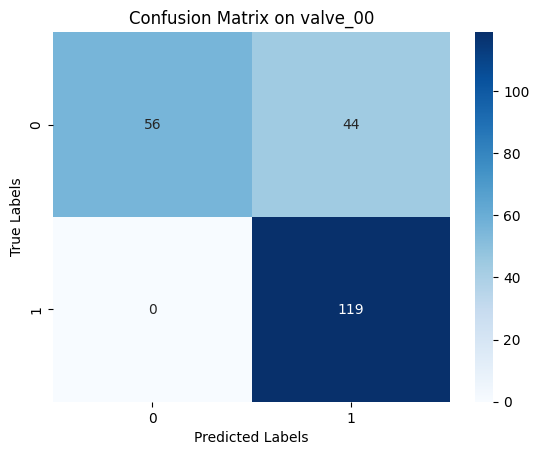

Accuracy: 0.7991
True Positive Rate (Recall): 1.0000
False Positive Rate: 0.4400
Precision: 0.7301
F1-Score: 0.8440


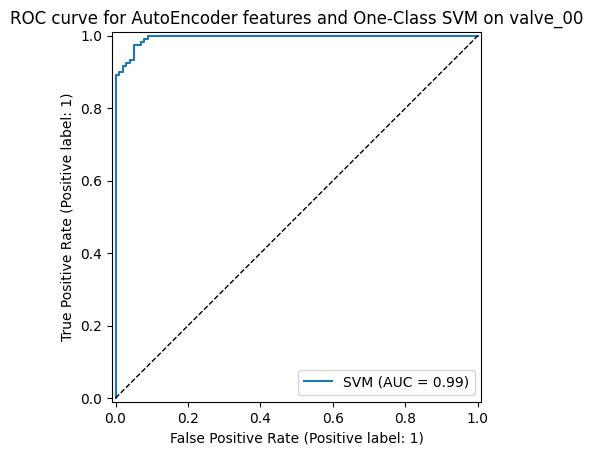

In [524]:
evaluation_metrics(y_true, predicted_score)

metrics.RocCurveDisplay.from_predictions(y_true, decision_score, name="SVM")
plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.title(f"ROC curve for AutoEncoder features and One-Class SVM on {MACHINE}");

### Isolation Forest

In [525]:
# TODO : Define IsolationForest here
# TODO : Fit IsolationForest here using training data
# TODO : Report essential evaluation metrics
# ===================================
isolation_forest = IsolationForest(contamination = 0.5)
isolation_forest.fit(extracted_features_train)
y_test_proba_iso_forest = -isolation_forest.decision_function(extracted_features_test)
predicted_score = isolation_forest.predict(extracted_features_test) # PREDICTING ON TEST SET
predicted_score = (predicted_score == -1).astype(int)
# ===================================

roc_auc = metrics.roc_auc_score(y_true, y_test_proba_iso_forest)
print(f"ROC AUC Score on Test Set: {roc_auc:.4f}")

accuracy = metrics.accuracy_score(y_true, predicted_score)
print(f"Accuracy Score on Test Set: {accuracy:.4f}")

f1 = metrics.f1_score(y_true, predicted_score)
print(f"F1 Score on Test Set: {f1:.4f}")

ROC AUC Score on Test Set: 0.9749
Accuracy Score on Test Set: 0.7808
F1 Score on Test Set: 0.8322


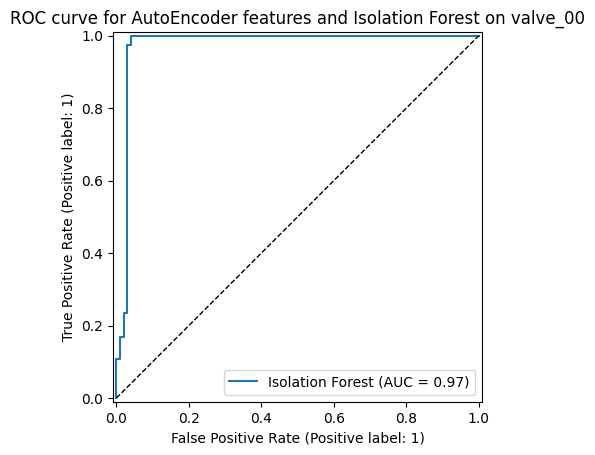

In [526]:
metrics.RocCurveDisplay.from_predictions(y_true, y_test_proba_iso_forest, name="Isolation Forest")
plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.title(f"ROC curve for AutoEncoder features and Isolation Forest on {MACHINE}");

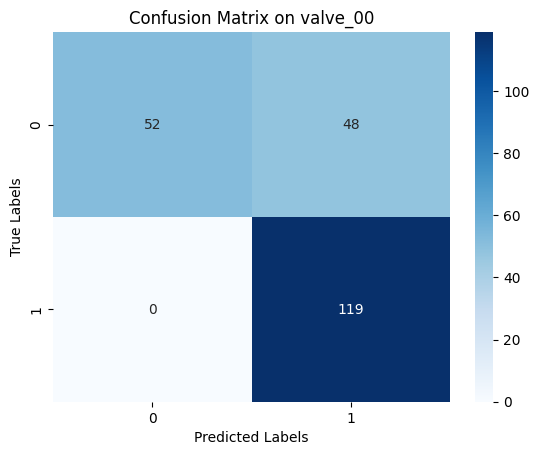

Accuracy: 0.7808
True Positive Rate (Recall): 1.0000
False Positive Rate: 0.4800
Precision: 0.7126
F1-Score: 0.8322


In [527]:
evaluation_metrics(y_true, predicted_score)


# Question 3
### Instead of using AutoEncoder features, apply PCA to project the MEL-spectrogram into a smaller dimensional space, then train (1) a One-Class SVM and (2) an Isolation Forest, and report the AUC scores.

PCA of the spectrograms to reduce the input dimension

In [528]:
# Extract spectrograms of training and testing
flatten_spectogram_train = []
for idx, (x, _) in enumerate(data_train):
    x = x.flatten()
    flatten_spectogram_train.append(x.numpy())
train_spec = np.array(flatten_spectogram_train)

flatten_spectogram_test = []
for idx, (x, _) in enumerate(data_test):
    x = x.flatten()
    flatten_spectogram_test.append(x.numpy())
test_spec = np.array(flatten_spectogram_test)

In [529]:
np.mean(train_spec)

np.float32(-34.590714)

In [530]:
np.mean(data_test.labels)
# np.sum(np.array(data_test.labels) == 1)

np.float64(0.54337899543379)

Apply PCA to fit and transform the training data and transform also the test data

In [531]:
from sklearn.decomposition import PCA

pca = PCA(n_components=64)

# TODO : Fit and transform the training data (train_spec)
# TODO : Transform the testing data (test_spec)
# ===================================
train_spec_pca = pca.fit_transform(train_spec)
test_spec_pca = pca.transform(test_spec)
# ===================================

## One-Class SVM using the new PCA features

In [532]:
y_true = data_test.labels

In [574]:
# TODO : Define the OneClassSVM here
# TODO : Fit OneClassSVM here using PCA features
# TODO : Report essential evaluation metrics
# ===================================
svm_pca = OneClassSVM(gamma = 'scale', nu = 0.54)
svm_pca.fit(train_spec_pca)
predicted_score_proba = -svm_pca.score_samples(test_spec_pca)
# y_test_proba_svm_pca = -svm_pca.decision_function(test_spec_pca)
predicted_score = svm_pca.predict(test_spec_pca) # PREDICTING ON TEST SET
predicted_score = (predicted_score == -1).astype(int)

print('PCA, then One-Class SVM Results:')

# if using these thresholded results for the ROC curve, then AUC will be worse!! instead use y_test_proba_svm_pca
roc_auc = metrics.roc_auc_score(y_true, predicted_score_proba)
print(f"ROC AUC Score on Test Set: {roc_auc:.4f}")

accuracy = metrics.accuracy_score(y_true, predicted_score)
print(f"Accuracy Score on Test Set: {accuracy:.4f}")

f1 = metrics.f1_score(y_true, predicted_score)
print(f"F1 Score on Test Set: {f1:.4f}")
# ===================================


PCA, then One-Class SVM Results:
ROC AUC Score on Test Set: 0.9941
Accuracy Score on Test Set: 0.8539
F1 Score on Test Set: 0.8815


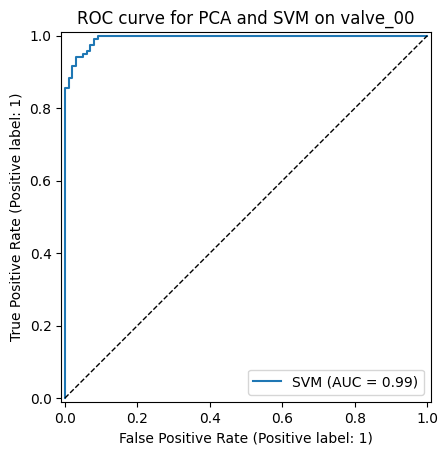

In [575]:
metrics.RocCurveDisplay.from_predictions(y_true, predicted_score_proba, name="SVM")
plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.title(f"ROC curve for PCA and SVM on {MACHINE}");


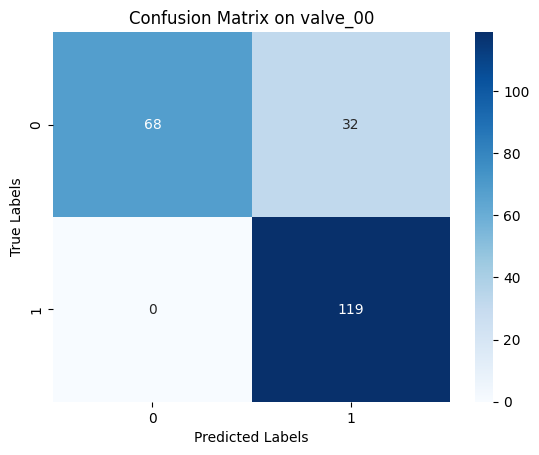

Accuracy: 0.8539
True Positive Rate (Recall): 1.0000
False Positive Rate: 0.3200
Precision: 0.7881
F1-Score: 0.8815


In [576]:
# For the One-Class SVM
evaluation_metrics(y_true, predicted_score)

## Isolation Forest using the new PCA features

In [698]:
# TODO : Define IsolationForest here
# TODO : Fit IsolationForest here using PCA features
# TODO : Report essential evaluation metrics
# ===================================
isolation_forest_pca = IsolationForest(random_state=0, contamination = 0.5).fit(train_spec_pca)
predicted_score_proba = -isolation_forest_pca.score_samples(test_spec_pca)
predicted_score = isolation_forest_pca.predict(test_spec_pca) # PREDICTING ON TEST SET
predicted_score = (predicted_score == -1).astype(int)

print('Isolation Forest Results')
roc_auc = metrics.roc_auc_score(y_true, predicted_score_proba)
print(f"ROC AUC Score on Test Set: {roc_auc:.4f}")

accuracy = metrics.accuracy_score(y_true, predicted_score)
print(f"Accuracy Score on Test Set: {accuracy:.4f}")

f1 = metrics.f1_score(y_true, predicted_score)
print(f"F1 Score on Test Set: {f1:.4f}")
# ===================================

Isolation Forest Results
ROC AUC Score on Test Set: 0.6171
Accuracy Score on Test Set: 0.5160
F1 Score on Test Set: 0.4536


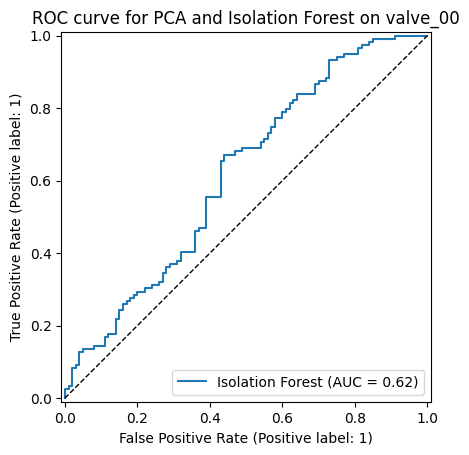

In [699]:
metrics.RocCurveDisplay.from_predictions(y_true, predicted_score_proba, name="Isolation Forest")
plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.title(f"ROC curve for PCA and Isolation Forest on {MACHINE}");

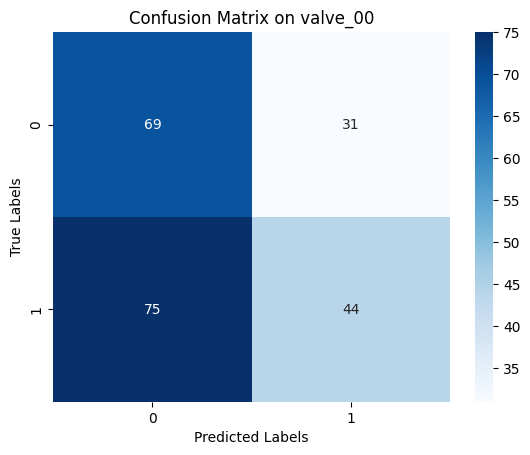

Accuracy: 0.5160
True Positive Rate (Recall): 0.3697
False Positive Rate: 0.3100
Precision: 0.5867
F1-Score: 0.4536


In [700]:
# For the Isolation Forest!
evaluation_metrics(y_true, predicted_score)

# Question 4
### Determine an appropriate threshold for distinguishing anomalies based on the given results, and compute the following metrics: Accuracy, True Positive Rate (TPR), False Positive Rate (FPR), and F1-score.

We will be looking into methods to choose the ideal threshold for 

We will be using two methods to find a "good" threshold: the first will use the training reconstruction loss 

Note: We will be computing the "optimal" threshold using Youden's J statistic in order to find a good first guess. However since in practice, in anomaly detection it is more important to optimize for True Positive Rate, then we could also imagine a further exercise trying to find the "optimal" threshold for us based on some cost optimisation (using the cost of a false positive vs. false negative). For this exercise set we will stick to Youden's J-statistic which weighs both TPR and FPR equally high. 

In [701]:
# TODO : Define a threshold based on test loss for classification
# TODO : Report accuracy, TPR, FPR, F1-Score
# ===================================
def percentile_thresholding(percentile, train_losses, test_losses):
   
    threshold = np.percentile(train_losses, percentile)
    print(f"Threshold (at {percentile}th percentile): {threshold}")

    # Classify test samples based on the threshold
    y_pred = (y_scores >= threshold).astype(int)

    tn, fp, fn, tp = metrics.confusion_matrix(y_true, y_pred).ravel()

    accuracy = metrics.accuracy_score(y_true, y_pred)
    tpr_value = metrics.recall_score(y_true, y_pred)
    precision = metrics.precision_score(y_true, y_pred)
    f1 = metrics.f1_score(y_true, y_pred)
    fpr_value = fp / (fp + tn)
    auc = metrics.roc_auc_score(y_true, y_scores)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"True Positive Rate (Recall): {tpr_value:.4f}")
    print(f"False Positive Rate: {fpr_value:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"AUC: {auc:.4f}")
    print('----------')

    return threshold
# ===================================

In [702]:
def plot_reconstruction_loss(percentile, threshold):
    plt.figure(figsize=(10, 6))
    plt.hist(train_losses, bins=50, alpha=0.5, label='Training Losses (Normal)')
    plt.hist(y_scores[np.array(y_true) == 0], bins=50, alpha=0.5, label='Test Losses (Normal)')
    plt.hist(y_scores[np.array(y_true) == 1], bins=50, alpha=0.5, label='Test Losses (Anomalies)')
    plt.axvline(threshold, color='red', linestyle='--', label=f'Threshold ({percentile}th percentile)')
    plt.title('Reconstruction Losses')
    plt.xlabel('Loss')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

In [703]:
threshold_50 = percentile_thresholding(50, train_losses, test_losses)
threshold_70 = percentile_thresholding(70, train_losses, test_losses)
threshold_95 = percentile_thresholding(95, train_losses, test_losses)

Threshold (at 50th percentile): 22.248567581176758
Accuracy: 0.3881
True Positive Rate (Recall): 0.2605
False Positive Rate: 0.4600
Precision: 0.4026
F1-Score: 0.3163
AUC: 0.3529
----------
Threshold (at 70th percentile): 25.550132751464844
Accuracy: 0.4475
True Positive Rate (Recall): 0.1513
False Positive Rate: 0.2000
Precision: 0.4737
F1-Score: 0.2293
AUC: 0.3529
----------
Threshold (at 95th percentile): 39.74610900878906
Accuracy: 0.4749
True Positive Rate (Recall): 0.0420
False Positive Rate: 0.0100
Precision: 0.8333
F1-Score: 0.0800
AUC: 0.3529
----------


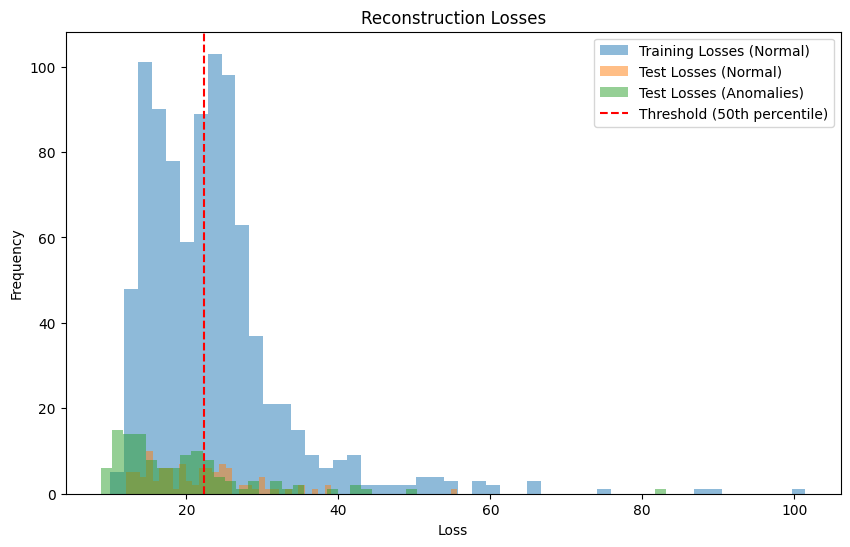

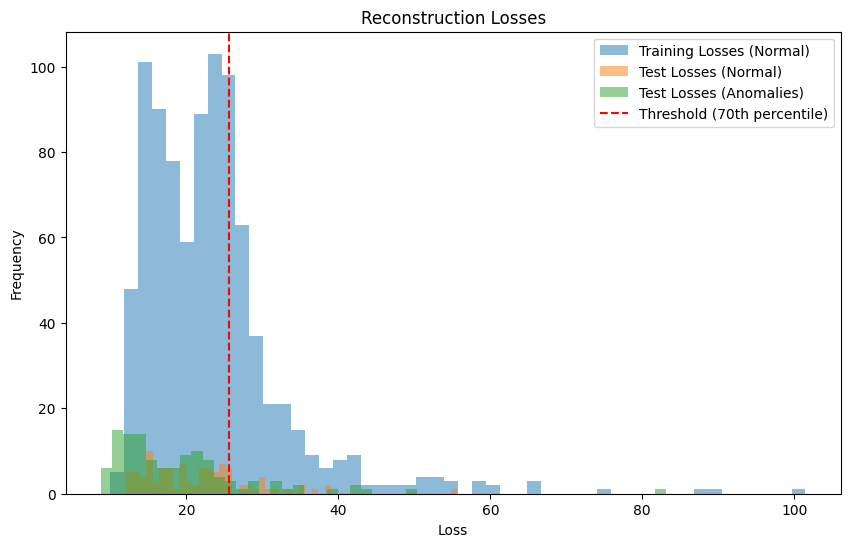

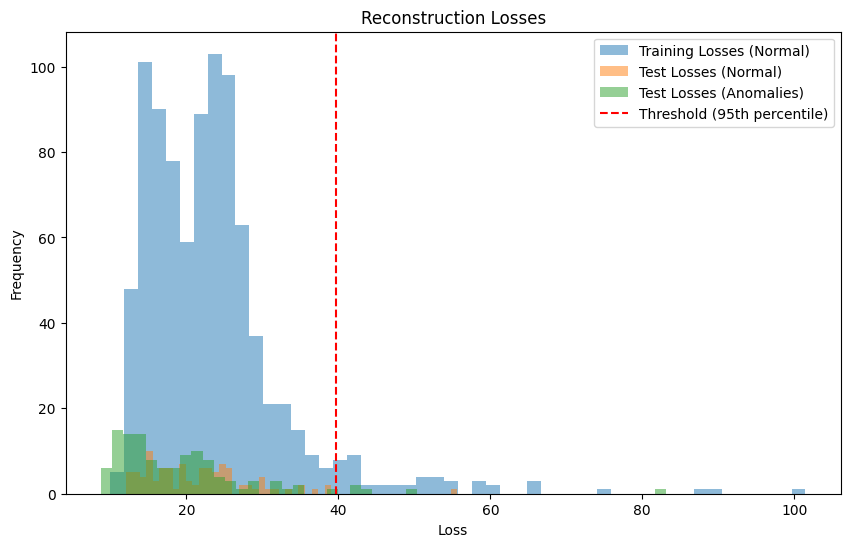

In [704]:
plot_reconstruction_loss(50, threshold_50)
plot_reconstruction_loss(70, threshold_70)
plot_reconstruction_loss(95, threshold_95)

In [705]:
def compute_Youden_J_stat(y_true, y_scores):
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_scores)

    # Compute Youden's J statistic
    J_stat = tpr - fpr
    optimal_idx = np.argmax(J_stat)
    optimal_threshold = thresholds[optimal_idx]
    print(f"Optimal Threshold (Youden's J): {optimal_threshold:.4f}")

    return fpr, tpr, thresholds, J_stat, optimal_threshold, optimal_idx

In [706]:
def plot_auc_with_YoudenJ(fpr, tpr, roc_auc, optimal_idx, MACHINE, title='ROC Curve'):
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'Autoencoder (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', label='Optimal Threshold')
    plt.title(f'{title}: {MACHINE}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.legend()
    plt.show()

In [707]:
def plot_Youden_J(thresholds, J_stat, optimal_idx, title="Youden's J Statistic vs. Thresholds"):
    plt.figure(figsize=(8, 6))
    plt.plot(thresholds, J_stat, label="Youden's J Statistic")
    plt.scatter(thresholds[optimal_idx], J_stat[optimal_idx], color='red', label=f'Optimal Threshold = {thresholds[optimal_idx]:.4f}')
    plt.title(title)
    plt.xlabel('Threshold')
    plt.ylabel("Youden's J Statistic")
    plt.legend()
    plt.tight_layout()
    plt.show()

Optimal Threshold (Youden's J): 39.2053


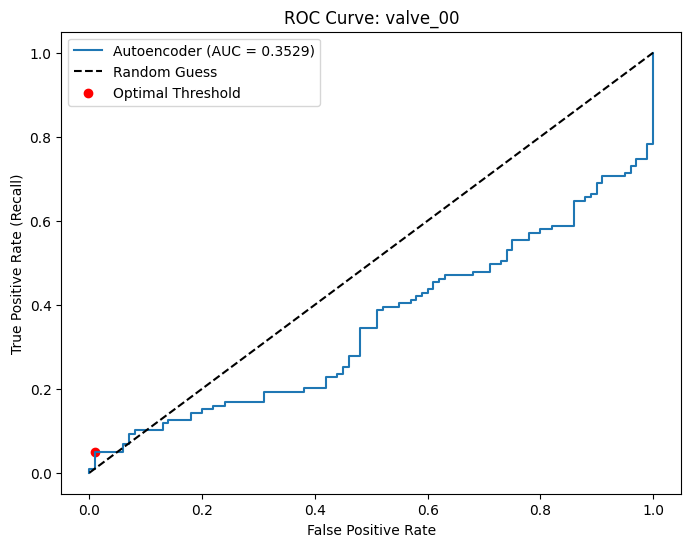

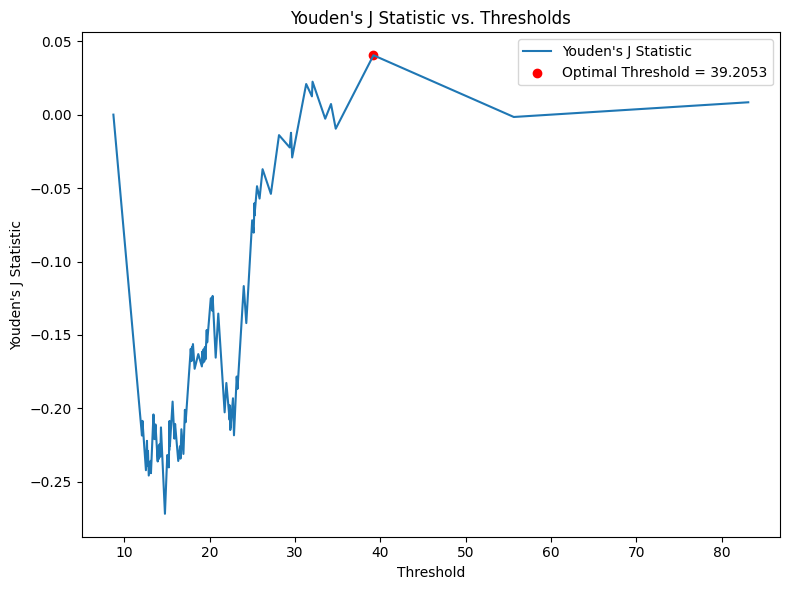

In [708]:
roc_auc = metrics.roc_auc_score(y_true, y_scores)
fpr, tpr, thresholds, J_stat, optimal_threshold, optimal_idx = compute_Youden_J_stat(y_true, y_scores)

plot_auc_with_YoudenJ(fpr, tpr, roc_auc, optimal_idx, MACHINE)
plot_Youden_J(thresholds, J_stat, optimal_idx)

In [709]:
y_pred = (y_scores >= optimal_threshold).astype(int)

tn, fp, fn, tp = metrics.confusion_matrix(y_true, y_pred).ravel()
accuracy = metrics.accuracy_score(y_true, y_pred)
tpr_value = metrics.recall_score(y_true, y_pred)
precision = metrics.precision_score(y_true, y_pred)
f1 = metrics.f1_score(y_true, y_pred)
fpr_value = fp / (fp + tn)

# Print the results
print(f"Accuracy: {accuracy:.4f}")
print(f"True Positive Rate (Recall): {tpr_value:.4f}")
print(f"False Positive Rate: {fpr_value:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1-Score: {f1:.4f}")

Accuracy: 0.4795
True Positive Rate (Recall): 0.0504
False Positive Rate: 0.0100
Precision: 0.8571
F1-Score: 0.0952
